In [1]:
import numpy as np
import scipy.io
import xarray as xr
import os
import pandas as pd
from datetime import datetime, date, time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import cmocean.cm as cmo
import warnings


warnings.filterwarnings('ignore')

import data_loading


In [2]:
ds_CTD = data_loading.get_CTD(2019)
ds_LADCP = data_loading.get_LADCP(2019)
bathy = data_loading.get_bathy()
proj = ccrs.Mercator(central_longitude=4.5, min_latitude=38.0, max_latitude=45.0, latitude_true_scale=42.0)

In [3]:
ds_CTD

<xarray.Dataset>
Dimensions:      (time: 118, depth: 2901)
Coordinates:
  * time         (time) datetime64[ns] 2019-06-08T08:31:14.999992 ... 2019-07...
  * depth        (depth) float64 0.0 0.9921 1.984 ... 2.856e+03 2.857e+03
    idx          (time) int64 0 1 2 3 4 5 6 7 ... 111 112 113 114 115 116 117
    latitude     (time) float64 42.98 42.95 42.25 41.97 ... 42.67 42.83 42.92
    longitude    (time) float64 5.668 5.644 4.983 4.651 ... 6.133 6.131 6.132
Data variables:
    temperature  (time, depth) float64 nan nan 18.5 18.57 ... nan nan nan nan
    salinity     (time, depth) float64 nan nan 38.01 38.01 ... nan nan nan nan

In [4]:
sections = {
    'Diag_1': {
        'CTD_idx': list(range(71, 78))+list(range(102, 104))+list(range(106, 111)),
        'LADCP_idx': list(range(70, 77))+list(range(101, 103))+list(range(105, 110)),
    },
    'Diag_2': {
        'CTD_idx': list(range(92, 102)) + [104, 105] + list(range(111, 114)),
        'LADCP_idx': list(range(91, 101)) + [103, 104] + list(range(110, 113)),
    },
    'Nice_Corse': {
        'CTD_idx': list(range(22,25)) + list(range(33,40)),
        'LADCP_idx':  list(range(21,24)) + list(range(32,39))
    }
}

for section_name, dict in sections.items():
    ds_section = ds_CTD.where(ds_CTD.idx.isin(dict['CTD_idx']), drop=True)
    ds_section = ds_section.sortby('latitude', ascending=False)
    ds_section['idx'] = range(len(ds_section.latitude))

    ds_section_LADCP = ds_LADCP.where(ds_LADCP.idx.isin(dict['LADCP_idx']), drop=True)
    ds_section_LADCP = ds_section_LADCP.sortby('latitude', ascending=False)
    ds_section_LADCP['time'] = ds_section.time
    ds_section_LADCP['idx'] = ds_section.idx
    ds_section_LADCP['latitude'] = ds_section.latitude
    ds_section_LADCP['longitude'] = ds_section.longitude

    dist = np.concatenate([np.array([0]), gsw.distance(ds_section.longitude, ds_section.latitude).cumsum()]) # distance in m
    x = np.array
    
    ds_section['density'] = gsw.sigma0(ds_section.salinity, ds_section.temperature)

    ds_section['distance'] = xr.DataArray(dist, dims='idx', coords={'idx': ds_section.idx})
    ds_section_LADCP['distance'] = xr.DataArray(dist, dims='idx', coords={'idx': ds_section.idx})

    R = 6371e3 # Earth radius in meters
    x = np.radians(ds_section.longitude - ds_section.longitude.mean()) * R * np.cos(np.radians(ds_section.latitude.mean()))
    y = np.radians(ds_section.latitude - ds_section.latitude.mean()) * R

    x_0 = x.values[0]
    y_0 = y.values[0]
    x_1 = x.values[-1]
    y_1 = y.values[-1]

    t_x = x_1 - x_0
    t_y = y_1 - y_0
    norm_t = np.sqrt(t_x**2 + t_y**2)
    t_x /= norm_t
    t_y /= norm_t

    n_x = -t_y
    n_y = t_x


    dict['CTD'] = ds_section
    dict['LADCP'] = ds_section_LADCP
    dict['n_x'] = n_x
    dict['n_y'] = n_y


sections['Diag_1']['CTD']['temperature'][10, :] = (sections['Diag_1']['CTD']['temperature'][9, :] + sections['Diag_1']['CTD']['temperature'][11, :]) / 2
sections['Diag_1']['CTD']['salinity'][10, :] = (sections['Diag_1']['CTD']['salinity'][9, :] + sections['Diag_1']['CTD']['salinity'][11, :]) / 2
sections['Diag_1']['CTD']['density'][10, :] = (sections['Diag_1']['CTD']['density'][9, :] + sections['Diag_1']['CTD']['density'][11, :]) / 2


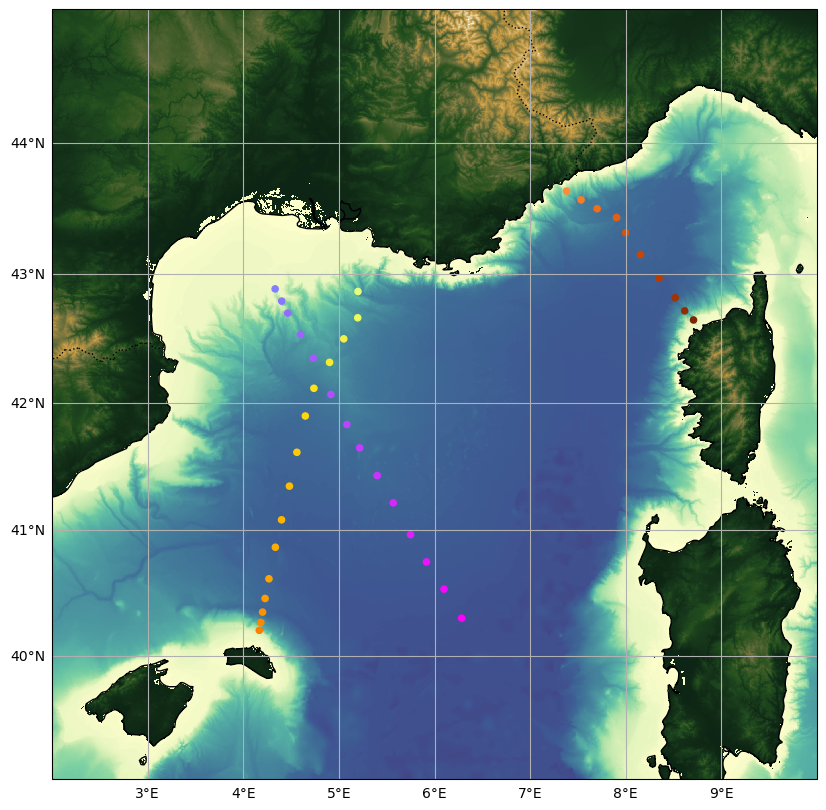

In [9]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': proj})
ax.set_extent([2, 10, 39, 45])
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':')

ax.add_feature(cfeature.OCEAN)
bathy.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmo.topo, add_colorbar=False)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

ds = sections['Nice_Corse']['CTD']
new_cmap = plt.cm.Oranges(np.linspace(0.5, 1, 100))
new_cmap = plt.matplotlib.colors.ListedColormap(new_cmap)
sc = ax.scatter(ds.longitude, ds.latitude, s=20, c=ds.idx, cmap=new_cmap, alpha=1, marker='o', transform=ccrs.PlateCarree())

ds = sections['Diag_1']['CTD']
new_cmap = plt.cm.cool(np.linspace(0.5, 1, 100))
new_cmap = plt.matplotlib.colors.ListedColormap(new_cmap)
sc = ax.scatter(ds.longitude, ds.latitude, s=20, c=ds.idx, cmap=new_cmap, alpha=1, marker='o', transform=ccrs.PlateCarree())

ds = sections['Diag_2']['CTD']
new_cmap = plt.cm.Wistia(np.linspace(0, 1, 100))
new_cmap = plt.matplotlib.colors.ListedColormap(new_cmap)
sc = ax.scatter(ds.longitude, ds.latitude, s=20, c=ds.idx, cmap=new_cmap, alpha=1, marker='o', transform=ccrs.PlateCarree())

plt.savefig('figs/sections_map.png', bbox_inches='tight')
plt.show()

In [10]:
def plot_section(section_name, max_depth = 300, thermal_wind = False, z_no_current = 1000):
    dict = sections[section_name]
    ds = dict['CTD']
    D = ds['density'].values
    min_density = np.nanmin(D)
    max_density = np.nanmax(D)
    nb_rows = 5 if thermal_wind else 4
    fig, axes = plt.subplots(nrows=nb_rows, ncols=1, figsize=(10, 15))

    # Temperature
    ax = axes[0]
    pcm = ax.contourf(ds.distance / 1e3, ds.depth, ds['temperature'].T, cmap=cmo.thermal, levels=100)
    cont = ax.contour(
        ds.distance / 1e3, 
        ds.depth, 
        D.T, 
        colors='black', 
        linewidths=0.5, 
        levels=np.linspace(min_density, max_density, 10)
    )
    ax.clabel(cont, fmt='%1.1f',fontsize=8)
    ax.set_ylim([0, max_depth])
    fig.colorbar(pcm, ax=ax, label='Temperature [°C]')
    ax.invert_yaxis()

    # Salinity
    ax = axes[1]
    pcm = ax.contourf(ds.distance / 1e3, ds.depth, ds['salinity'].T, cmap=cmo.haline, levels=100)
    cont = ax.contour(
        ds.distance / 1e3, 
        ds.depth, 
        D.T, 
        colors='black', 
        linewidths=0.5, 
        levels=np.linspace(min_density, max_density, 10)
    )
    ax.clabel(cont, fmt='%1.1f',fontsize=8)
    fig.colorbar(pcm, ax=ax, label='Salinity [PSU]')
    ax.set_ylim([0, max_depth])
    ax.invert_yaxis()

    # Density
    ax = axes[2]
    new_cmap = cmo.dense(np.linspace(0, 0.8, 500))
    new_cmap = plt.matplotlib.colors.ListedColormap(new_cmap)   
    pcm = ax.contourf(ds.distance / 1e3, ds.depth, ds['density'].T, cmap=new_cmap, levels=100)
    cont = ax.contour(
        ds.distance / 1e3, 
        ds.depth, 
        D.T, 
        colors='black', 
        linewidths=0.5, 
        levels=np.linspace(min_density, max_density, 10)
    )
    ax.clabel(cont, fmt='%1.1f',fontsize=8)
    fig.colorbar(pcm, ax=ax, label='Potential Density [kg/m^3]')
    ax.set_ylim([0, max_depth])
    ax.invert_yaxis()

   

    if not thermal_wind:
        ds_LADCP = dict['LADCP']
        n_x = dict['n_x']
        n_y = dict['n_y']
        ax = axes[3]
        pcm = ax.contourf(ds_LADCP.distance / 1e3, ds_LADCP.depth, ds_LADCP['U'].T * n_x + ds_LADCP['V'].T * n_y, cmap=cmo.balance, norm=plt.matplotlib.colors.CenteredNorm(), levels=100)
        fig.colorbar(pcm, ax=ax, label='Cross-section current [m/s]')
        ax.set_ylim([0, max_depth])
        ax.invert_yaxis()

    else:

        ds = dict['CTD'].sel(depth=slice(0, z_no_current))

        D = ds['density'].values

        g = 9.81
        omega = 2 * np.pi / 24 / 3600
        f = 2 * omega * np.sin(np.radians(float(ds.latitude.mean())))

        rho_0 = 1025. # kg/m^3

        drhodx = np.empty((len(ds.distance)-1, len(ds.depth)))
        dist_centroids = (ds.distance.values[1:] + ds.distance.values[:-1]) / 2
        for i in range(len(ds.distance)-1):
            drhodx[i, :] = (D[i+1, :] - D[i, :]) / float((ds.distance[i+1] - ds.distance[i]))

        

        dudz = - g/f * drhodx / rho_0  # or -

        z = ds.depth.values

        u = np.zeros_like(drhodx)
        u[:, -1] = 0
        for i in range(len(ds.depth)-2,-1,-1):
            u[:,i] = u[:,i+1] + dudz[:, i] * (z[i+1]-z[i])

        ds_LADCP = dict['LADCP']
        n_x = dict['n_x']
        n_y = dict['n_y']

        
        current_max = max(np.nanmax(np.abs(u)), np.nanmax(np.abs(ds_LADCP['U'].T * n_x + ds_LADCP['V'].T * n_y)))


        ax = axes[3]
        pcm = ax.contourf(dist_centroids/ 1e3, ds.depth, u.T, cmap=cmo.balance, levels=np.linspace(-current_max, current_max, 100))
        fig.colorbar(pcm, ax=ax, label='Thermal wind current [m/s]')
        cont = ax.contour(
            ds.distance / 1e3, 
            ds.depth, 
            D.T, 
            colors='black', 
            linewidths=0.5, 
            levels=np.linspace(min_density, max_density, 10)
        )
        ax.clabel(cont, fmt='%1.1f',fontsize=8)
        ax.set_ylim([0, max_depth])
        ax.invert_yaxis()

        ax = axes[4]
        pcm = ax.contourf(ds_LADCP.distance / 1e3, ds_LADCP.depth, ds_LADCP['U'].T * n_x + ds_LADCP['V'].T * n_y, cmap=cmo.balance, levels=np.linspace(-current_max, current_max, 100))
        fig.colorbar(pcm, ax=ax, label='LADCP current [m/s]')
        ax.set_ylim([0, max_depth])
        ax.invert_yaxis()




    ax.set_xlabel('Distance [km]')
    for ax in axes:
        ax.set_ylabel('Depth [m]')

    plt.tight_layout()
    plt.savefig(f'figs/sections_{section_name}.png', bbox_inches='tight')
    plt.show()


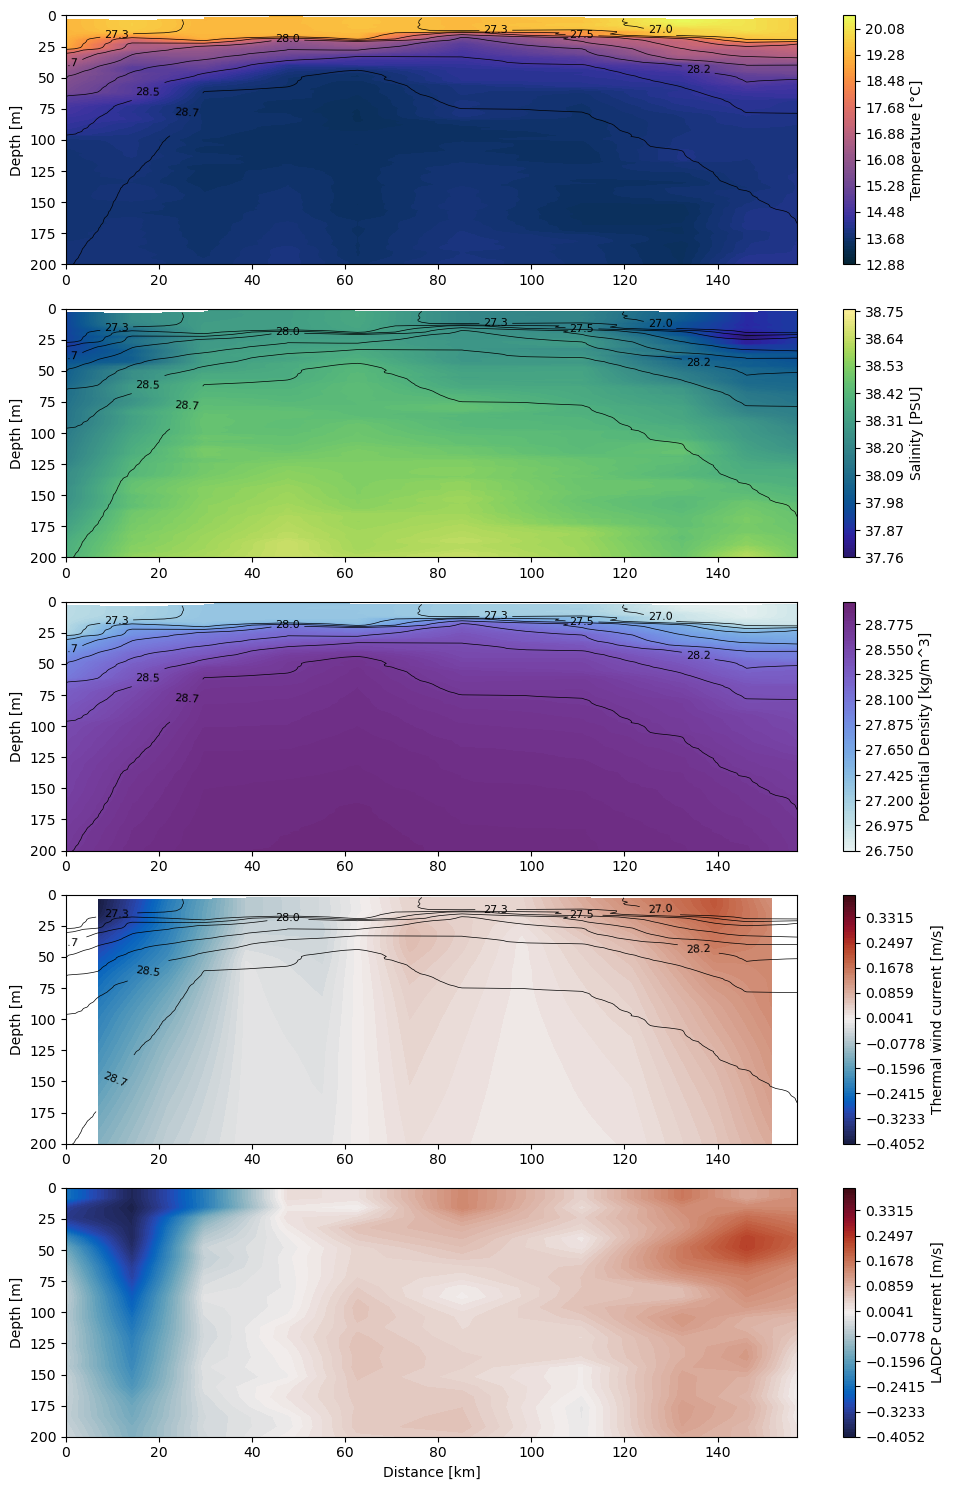

In [12]:
plot_section('Nice_Corse', max_depth=200, thermal_wind=True, z_no_current=750)

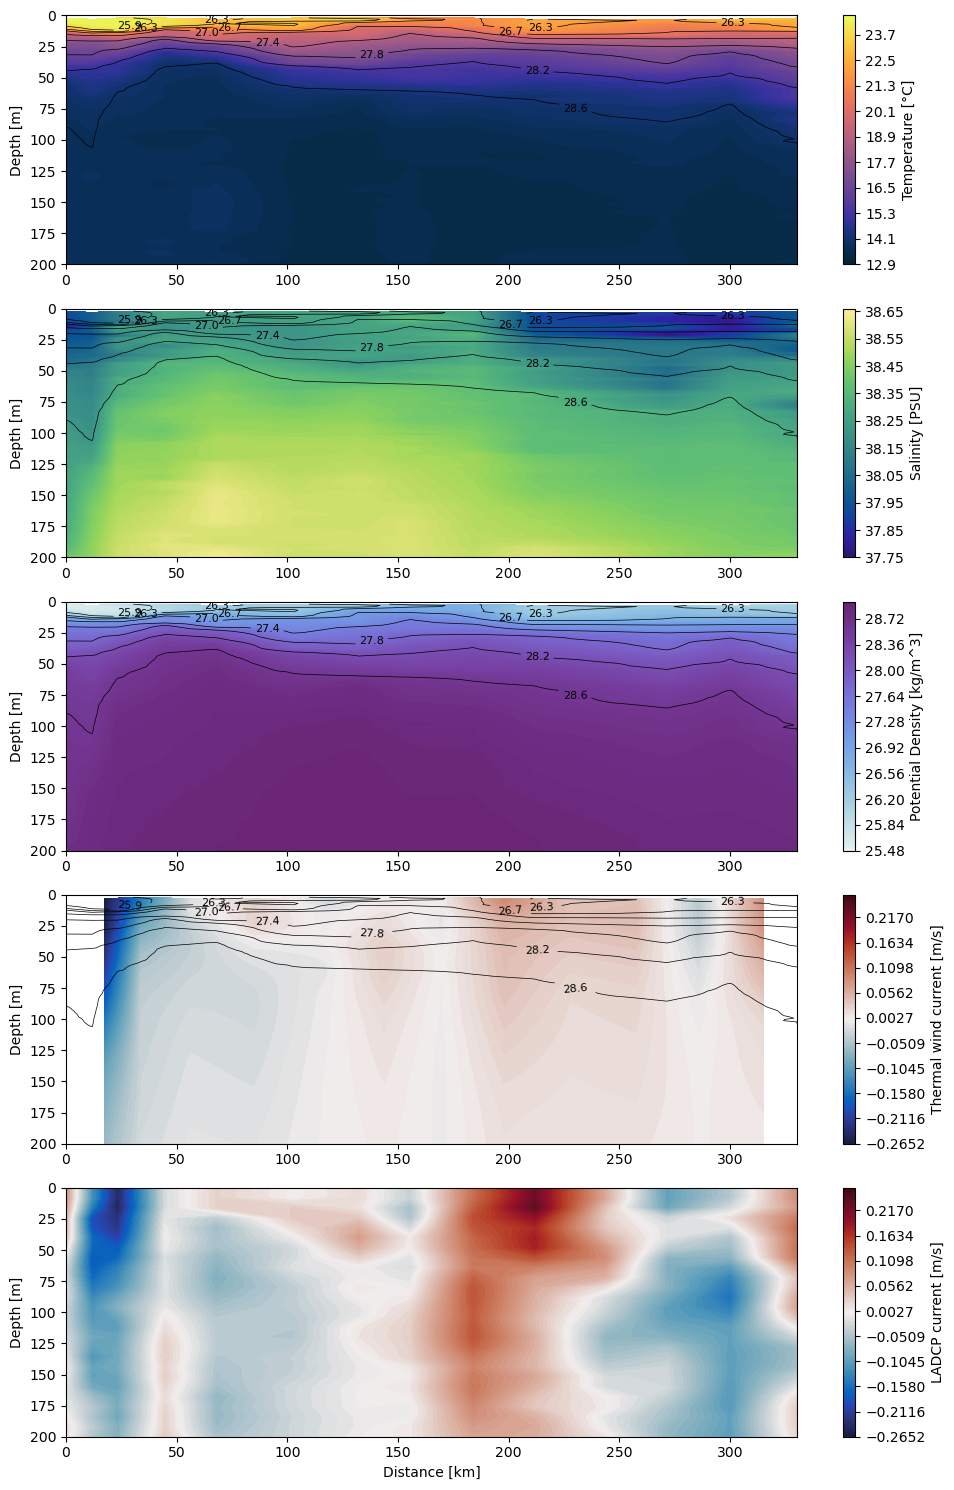

In [13]:
plot_section('Diag_1', max_depth=200, thermal_wind=True, z_no_current=500)

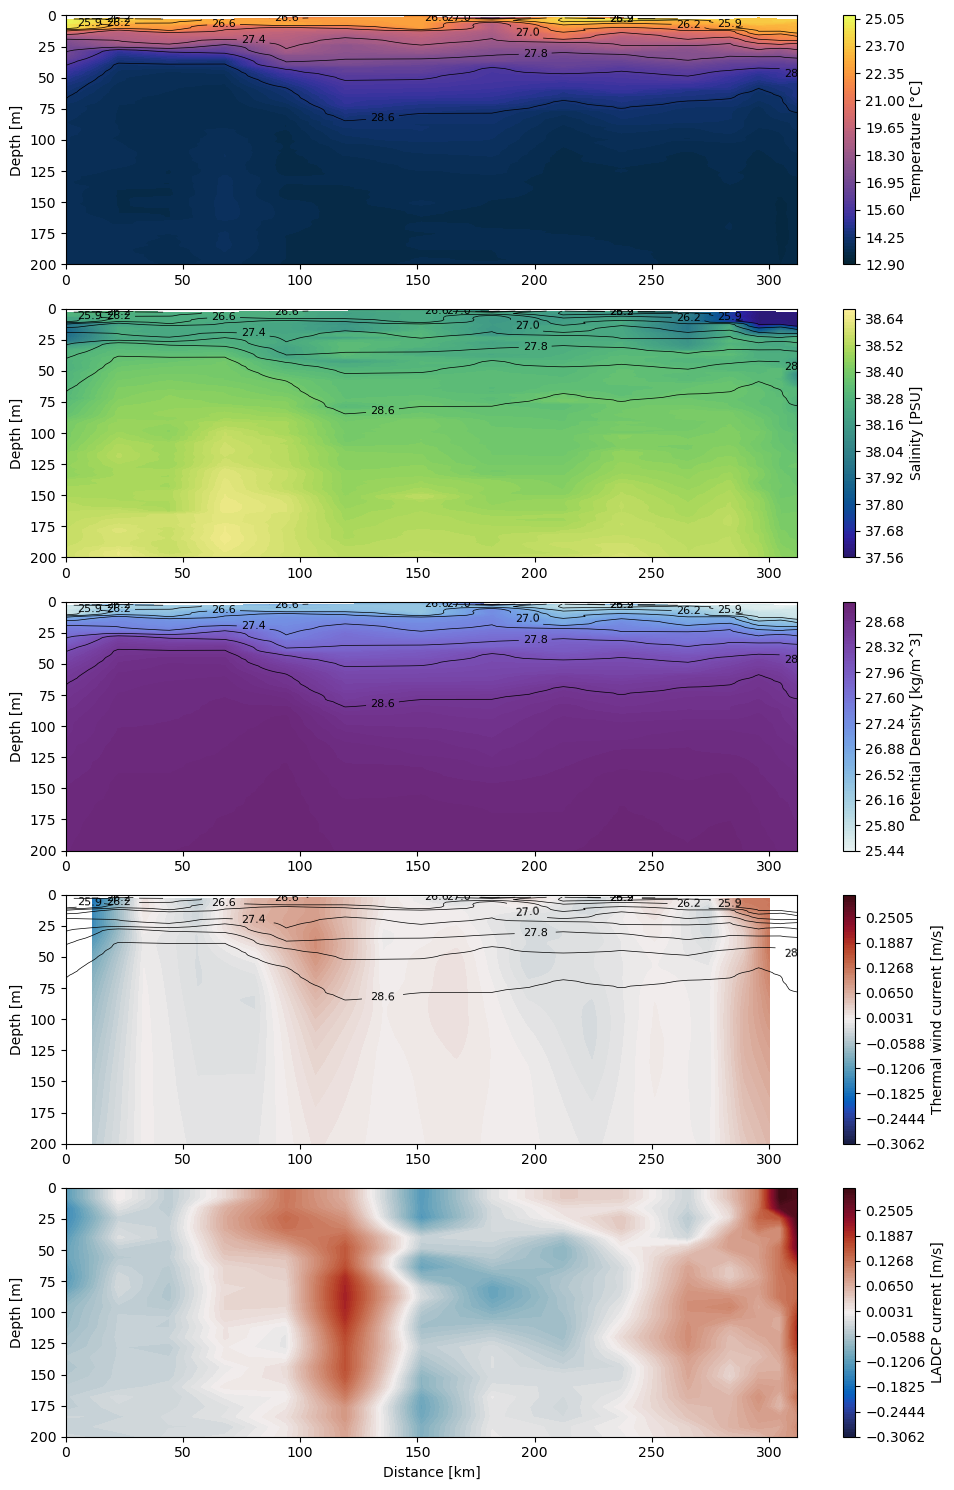

In [14]:
plot_section('Diag_2', max_depth=200, thermal_wind=True, z_no_current=1000)

# OLD

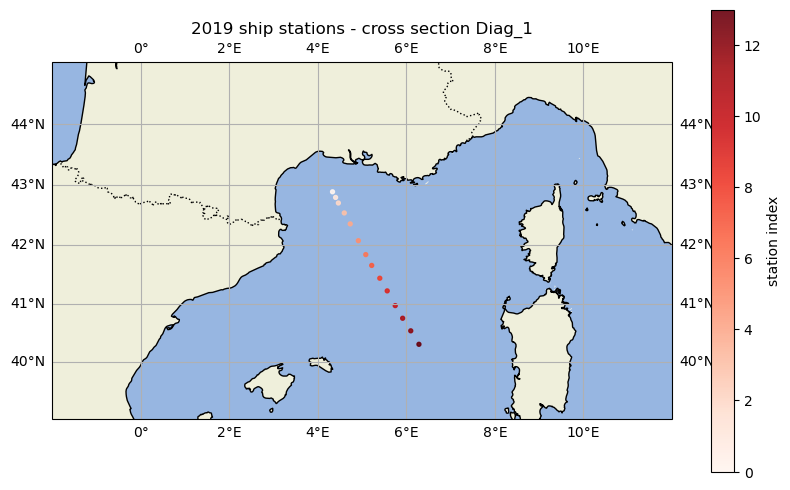

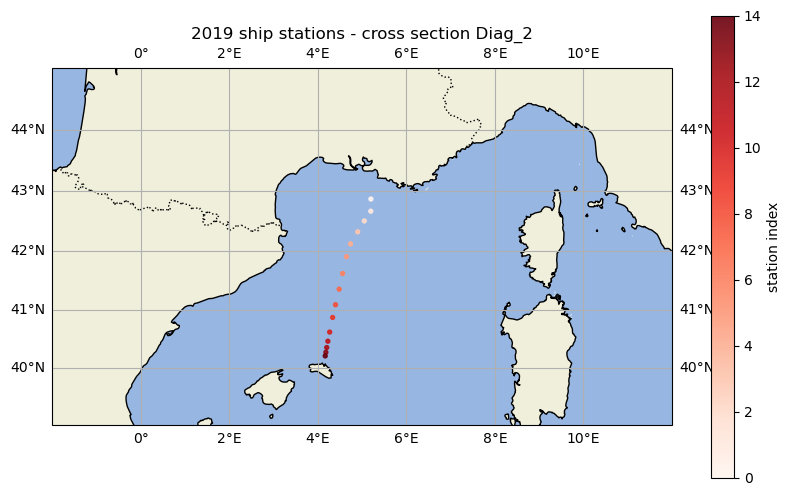

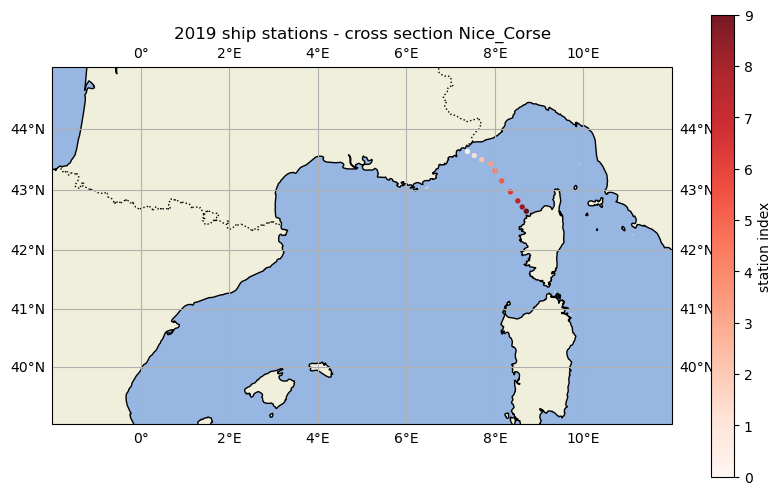

In [148]:
for section, dict in sections.items():
    ds = dict['ds']
    fig, ax = plt.subplots(figsize=(10,6), subplot_kw={'projection': proj})
    ax.set_extent([-2, 12, 39, 46])
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.OCEAN)
    ax.gridlines(draw_labels=True)

    sc= ax.scatter(ds.longitude, ds.latitude, s=8, c=ds.idx, cmap='Reds', alpha=.9, marker='o', transform=ccrs.PlateCarree())
    fig.colorbar(sc, ax=ax, label='station index')
    plt.title(f'2019 ship stations - cross section {section}')
    plt.show()


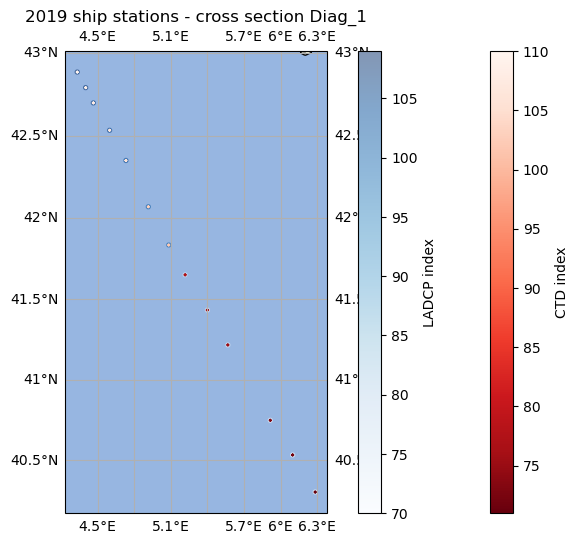

In [369]:
sections = {
    'Diag_1': {
        'CTD_idx': list(range(71, 74))+[75,76, 77]+list(range(102, 104))+list(range(106, 111)),
        'LADCP_idx': list(range(70, 73))+[74,75, 76]+list(range(101, 103))+list(range(105, 110)),
    }
}

for section, idxs in sections.items():
    sub_CTD = ds_CTD.where(ds_CTD.idx.isin(idxs['CTD_idx']), drop=True)
    sub_LADCP = ds_LADCP.where(ds_LADCP.idx.isin(idxs['LADCP_idx']), drop=True)
    fig, ax = plt.subplots(figsize=(10,6), subplot_kw={'projection': proj})
    #ax.set_extent([-2, 12, 39, 46])
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.OCEAN)
    ax.gridlines(draw_labels=True)

    sc_LADCP = ax.scatter(sub_LADCP.longitude, sub_LADCP.latitude, s=8, c=sub_LADCP.idx, cmap='Blues', alpha=.5, marker='o', transform=ccrs.PlateCarree())
    sc_CTD = ax.scatter(sub_CTD.longitude, sub_CTD.latitude, s=2, c=sub_CTD.idx, cmap='Reds_r', alpha=1, marker='x', transform=ccrs.PlateCarree())
    fig.colorbar(sc_CTD, ax=ax, label='CTD index')
    fig.colorbar(sc_LADCP, ax=ax, label='LADCP index')
    plt.title(f'2019 ship stations - cross section {section}')
    plt.show()
